
## Overview
Data Source: https://networkrepository.com/soc-tribes.php


In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from graphframes import GraphFrame
import os

spark = SparkSession.builder.appName("graphs")\
        .config('spark.jars.packages', 'io.graphframes:graphframes-spark4_2.13:0.10.0')\
        .master("local[*]")\
        .getOrCreate()

def toHtml(self):
    """Returns a dataframe - supports spark lines"""
    import cgi
    from itertools import islice
    if not self._support_repr_html:
        self._support_repr_html = True
    max_num_rows = max(self.sql_ctx._conf.replEagerEvalMaxNumRows(), 0)
    sock_info = self._jdf.getRowsToPython(
    max_num_rows, self.sql_ctx._conf.replEagerEvalTruncate())
    rows = islice(self.toLocalIterator(), 0, max_num_rows)
 
    html = "</pre>\n" #generate table header html += " \n" % " ".join(map(lambda x: cgi.escape(x), df.columns)) #generate table rows for row in rows: html += " \n" % "".join(map(lambda x: str(x), row)) 
    html += '<table border="1"><tbody><tr><th>%s</th></tr><tr><td>%s</td></tr></tbody></table><pre>\n'
    html += "only showing upto %d %s\n" % (max_num_rows, "row" if max_num_rows == 1 else "rows")
    return html

from pyspark.sql.dataframe import DataFrame
DataFrame._repr_html_ = toHtml
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/15 20:16:51 WARN Utils: Your hostname, Thuy-Trangs-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 10.146.116.1 instead (on interface en0)
26/01/15 20:16:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/Users/thuytrangskalska/anaconda3/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /Users/thuytrangskalska/.ivy2.5.2/cache
The jars for the packages stored in: /Users/thuytrangskalska/.ivy2.5.2/jars
io.graphframes#graphframes-spark4_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0520fd5a-894c-485d-8284-9462b663b44b;1.0
	confs: [default]
	found io.graphframes#graphframes-spark4_2.13;0.10.0 in central
	found io.graphframes#graphframes-graphx-spark4_2.13;0.10.0 in central
:: resolution report :: resol

In [2]:
# File location and type
file_location = "data/soc-tribes.edges"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "false"
delimiter = " "

# The applied options are for CSV files. For other file types, these will be ignored.
df_edges = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)
df_edges = df_edges.withColumnRenamed('_c0', 'src')
df_edges = df_edges.withColumnRenamed('_c1', 'dst')
df_edges = df_edges.withColumnRenamed('_c2', 'dir')
display(df_edges)

src,dst,dir
1,2,1
1,3,-1
2,3,-1
1,4,-1
3,4,1
1,5,-1
2,5,-1
1,6,-1
2,6,-1
3,6,1


In [3]:
df_nodes=df_edges.select("src").union(df_edges.select("dst")).distinct().withColumnRenamed('src', 'id')
display(df_nodes)

id
12
1
13
6
3
5
15
9
4
8


In [4]:
from graphframes import *
g = GraphFrame(df_nodes, df_edges)

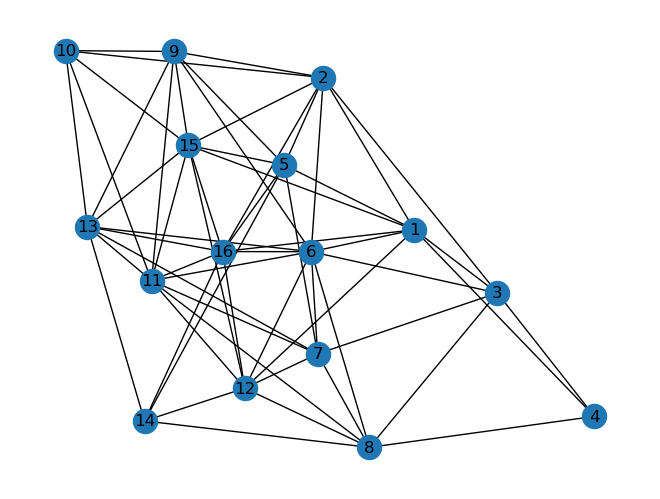

In [5]:
import networkx as nx
graph_pandas = g.edges.toPandas()
#print(graph_pandas)
nxg = nx.from_pandas_edgelist(graph_pandas, 'src', 'dst')
nx.draw(nxg, with_labels=True)

[(1, 2), (1, 3), (2, 3), (1, 4), (3, 4), (1, 5), (2, 5), (1, 6), (2, 6), (3, 6), (3, 7), (5, 7), (6, 7), (3, 8), (4, 8), (6, 8), (7, 8), (2, 9), (5, 9), (6, 9), (2, 10), (9, 10), (6, 11), (7, 11), (8, 11), (9, 11), (10, 11), (1, 12), (6, 12), (7, 12), (8, 12), (11, 12), (6, 13), (7, 13), (9, 13), (10, 13), (11, 13), (5, 14), (8, 14), (12, 14), (13, 14), (1, 15), (2, 15), (5, 15), (9, 15), (10, 15), (11, 15), (12, 15), (13, 15), (1, 16), (2, 16), (5, 16), (6, 16), (11, 16), (12, 16), (13, 16), (14, 16), (15, 16)]


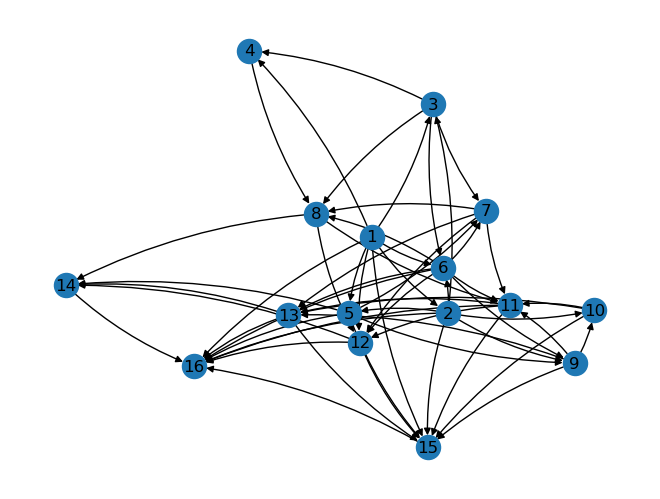

In [6]:
my_edges = [ (r.src, r.dst) for r in g.edges.collect()]
print(my_edges)

nxdg = nx.MultiDiGraph()
nxdg.add_edges_from(my_edges)
nx.draw(nxdg, with_labels=True, connectionstyle='arc3, rad=0.1')

In [8]:
from pyvis.network import Network
from IPython.display import display, HTML

#nt = Network(notebook=True, directed=True, font_color='red', cdn_resources='local')
nt = Network(notebook=True, directed=True, cdn_resources='remote')
nt.from_nx(nxg)
nt.prep_notebook()
#nt.set_options
#print(nt)
#nt.show('nt.html')
#displayHTML('nt.html')
#nt.save_graph("networkx-pyvis.html")
#nt.write_html('nx.html')
#nt.show('networkx-pyvis.html')
#displayHTML('nt.html')
#nt.sh
#displayHTML("networkx-pyvis.html")
nt.show("network.html")

network.html


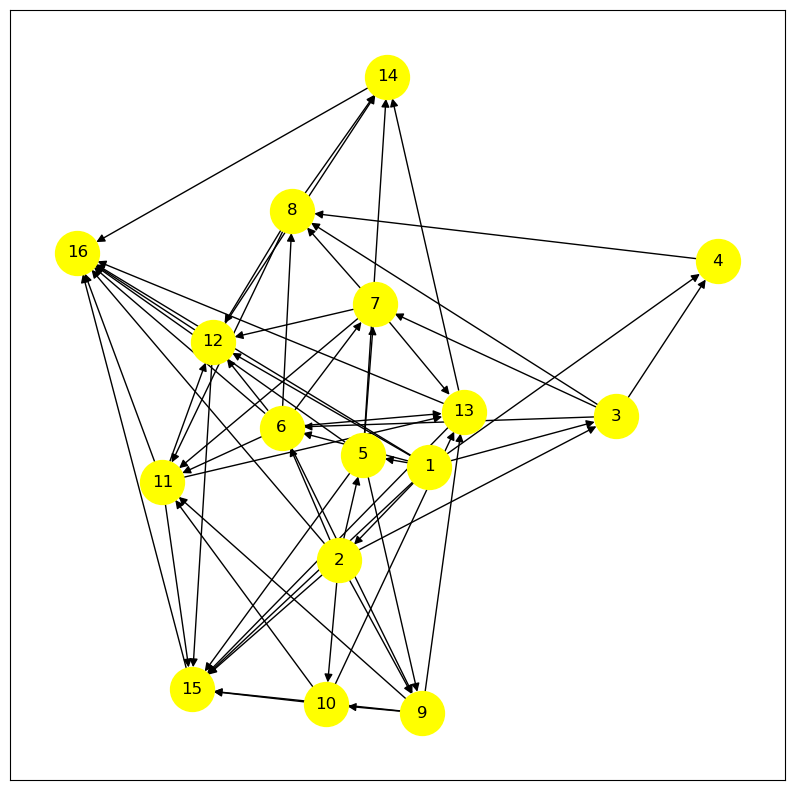

In [9]:
import networkx as nx
from graphframes import GraphFrame
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

def PlotGraph(edge_list):
    Gplot=nx.DiGraph()
    for row in edge_list.select('src','dst').take(100):
        Gplot.add_edge(row['src'],row['dst'])
    nx.draw_networkx(Gplot, arrows=True, with_labels=True, width=1, arrowstyle = '-|>', arrowsize = 12, node_color = 'yellow', node_size = 1000)

 

PlotGraph(g.edges)

In [10]:
pr_res = g.pageRank(resetProbability=0.15, tol=0.05)
pr_res.vertices.sort('pagerank', ascending=False).show()

26/01/15 20:20:41 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
26/01/15 20:20:42 WARN PageRank: Returned DataFrame is persistent and materialized!


+---+-------------------+
| id|           pagerank|
+---+-------------------+
| 16|    3.9967308368455|
| 15|   1.65738839946748|
| 14| 1.3285620083869218|
| 12| 1.1393364170796871|
| 11| 1.1258954348426695|
| 13| 1.0970666219749914|
|  8| 1.0095536169363624|
|  7| 0.6148923659978387|
|  9| 0.5789350733756969|
|  6| 0.5686187548972016|
| 10| 0.5613074387306993|
|  4| 0.5206756980676793|
|  3|0.48471840544553757|
|  5|0.48471840544553757|
|  2| 0.4367753486160153|
|  1|0.39482517389018335|
+---+-------------------+

